# Technical Part - Python3.10

1. Record yourself speaking for 10 seconds - 5 seconds when you are 20cm to the microphone and 5 seconds when you are 3m. The goal is that you'll have soft and loud speech segments in your recording.

a. Load the audio file.
    
i. If the audio was recorded in stereo, keep only a single channel.

In [1]:
import numpy as np
import librosa
import scipy.signal as signal
import soundfile as sf
import scipy

# Load the audio file
audio, sr = librosa.load('tp_q1.wav', sr=None, mono=True)
audio = audio.astype(np.float32)

ii. What is the sampling frequency of the audio?

In [2]:
print(f"Original Sampling Rate: {sr} Hz")

Original Sampling Rate: 44100 Hz


b. Set the sampling rate of the signal to 32KHz using scipy.signal.resample function
      (make sure that you cast the audio to np.float32)

In [9]:
duration = int(len(audio)/sr)
n_sample = 32000 * duration
audio_resampled = scipy.signal.resample(audio, n_sample)

c. Let’s downsample the audio to 16KHz:
    
i. using 2 methods:

1. Take every even sample from the audio
    
2. Resample the audio using scipy.signal.resample function (make
           sure that you cast the audio to np.float32)

In [10]:
resampled_16_1 = audio_resampled[::2]
n_samples_16 = int(len(audio_resampled) // 2)  # Half the samples for half the frequency
resampled_16_2 = scipy.signal.resample(audio_resampled, n_samples_16)

d. Write a function (you can use librosa/matplotlib) that given an input audio and its
sampling frequency it plots a figure containing 4 subplots:

i. Audio

ii. Spectrogram. The spectrogram should also contain:

1. Validate that you see 𝐹𝑚𝑎𝑥

2. Pitch contour on top of the spectrogram. You can use Praat or
pyworld python package

    a. Why are there missing timeframes in the pitch contour?
        •	This is common in non-periodic parts of the audio.

iii. Mel-Spectrogram

iv. Energy and RMS

v. Notes:

1. The energy, Spectrogram and Mel-Spectrogram should be
calculated using window_size of 20ms, and hop_size of 10ms.

2. Make sure that axes have labels specifying the units of
measurements (x axis- time [sec], y axis- frequency [Hz])
        

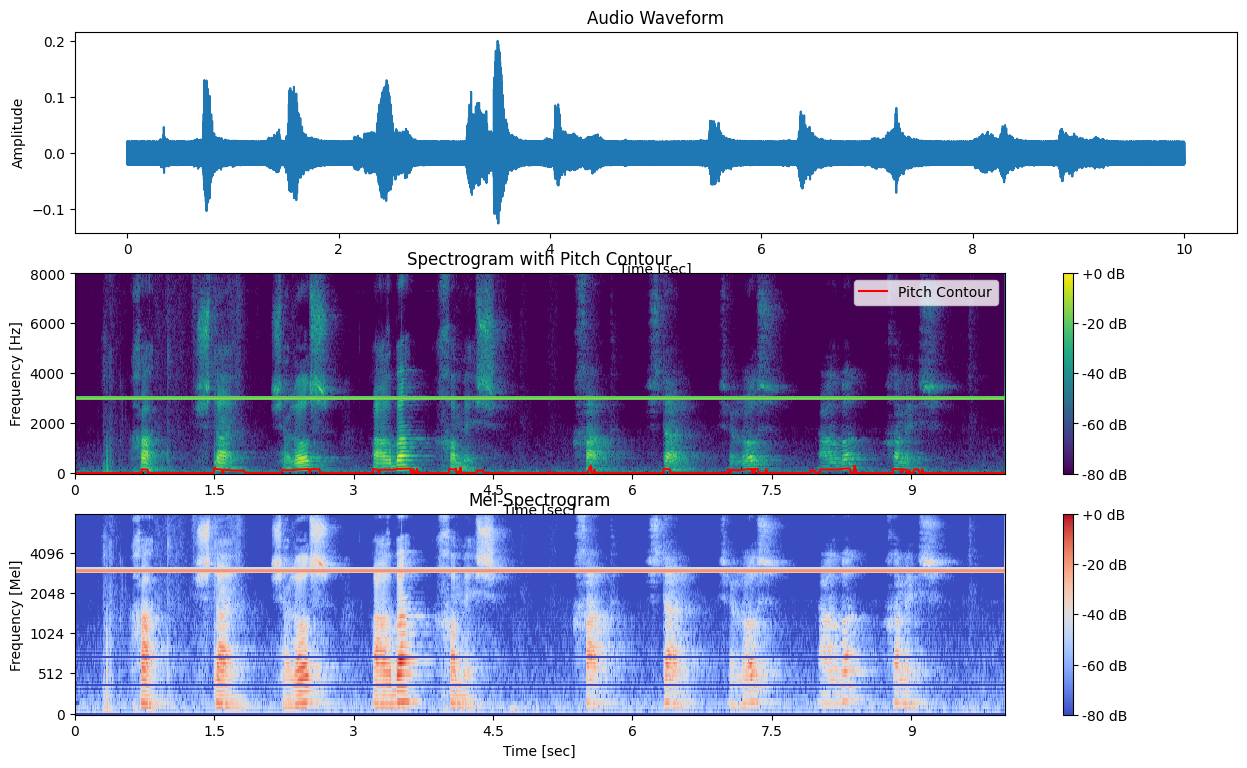

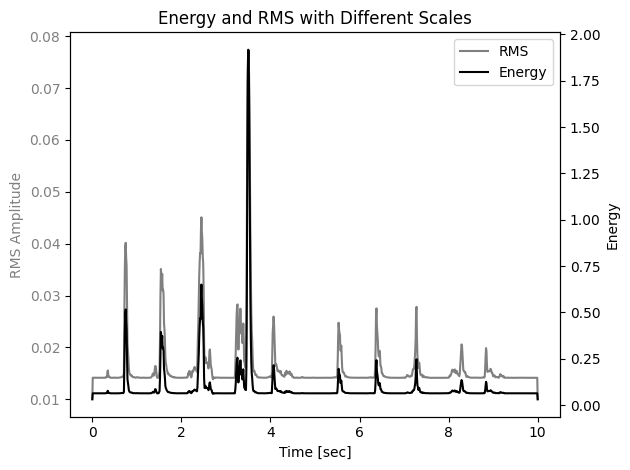

In [26]:
import matplotlib.pyplot as plt
import pyworld as pw

def plot_audio(audio, sr):
    # Plot settings:
    plt.figure(figsize=(15, 12))

    # Note 1: Parameters for analysis
    window_size = 0.02  # 20ms
    hop_size = 0.01  # 10ms

    # Plot i. Audio:
    time = np.linspace(0, len(audio)/ sr, len(audio))
    plt.subplot(4, 1, 1)
    plt.plot(time, audio)
    plt.title("Audio Waveform")
    plt.xlabel("Time [sec]")
    plt.ylabel("Amplitude")

    # ii. Spectrogram
    hop_length = int(hop_size * sr)
    n_fft = int(sr * window_size)
    spectrogram = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)
    # Pitch contour using pyworld
    _f0, t = pw.dio(audio.astype(np.float64), sr, frame_period=hop_size * 1000)  # Frame period in ms
    f0 = pw.stonemask(audio.astype(np.float64), _f0, t, sr)  # Refinement step

    plt.subplot(4, 1, 2)
    librosa.display.specshow(spectrogram_db, sr=sr, hop_length=hop_length, x_axis="time", y_axis="hz", cmap="viridis")
    plt.colorbar(format="%+2.0f dB")
    plt.plot(t, f0, color='red', linewidth=1.5, label='Pitch Contour')
    plt.title("Spectrogram with Pitch Contour")
    plt.xlabel("Time [sec]")
    plt.ylabel("Frequency [Hz]")
    plt.legend()

    # iii. Mel-Spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    plt.subplot(4, 1, 3)
    librosa.display.specshow(mel_spectrogram_db, sr=sr, hop_length=hop_length, x_axis="time", y_axis="mel", cmap="coolwarm")
    plt.colorbar(format="%+2.0f dB")
    plt.title("Mel-Spectrogram")
    plt.xlabel("Time [sec]")
    plt.ylabel("Frequency [Mel]")

    # iv. Energy and RMS
    rms = librosa.feature.rms(y=audio, frame_length=n_fft, hop_length=hop_length)
    energy = (rms**2) * n_fft  # RMS^2 * frame_length gives energy

    # Generate a time axis for plotting
    time_rms = np.arange(rms.shape[1]) * hop_size  # Number of frames matches RMS

    
    # Plot RMS on the primary Y-axis
    fig, ax1 = plt.subplots()
    ax1.plot(time_rms, rms[0], label="RMS", color="gray")
    ax1.set_xlabel("Time [sec]")
    ax1.set_ylabel("RMS Amplitude", color="gray")
    ax1.tick_params(axis='y', labelcolor="gray")

    # Add the secondary Y-axis for energy
    ax2 = ax1.twinx()
    ax2.plot(time_rms, energy[0], label="Energy", color="black")
    ax2.set_ylabel("Energy", color="black")
    ax2.tick_params(axis='y', labelcolor="black")

    plt.title("Energy and RMS with Different Scales")

    # Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

    # Show the plots
    plt.tight_layout()
    plt.show()

plot_audio(audio, sr)

e. Apply this function on the resampled audios from 1.b, and listen to both outputs-

i. Which one is better?

ii. Why?

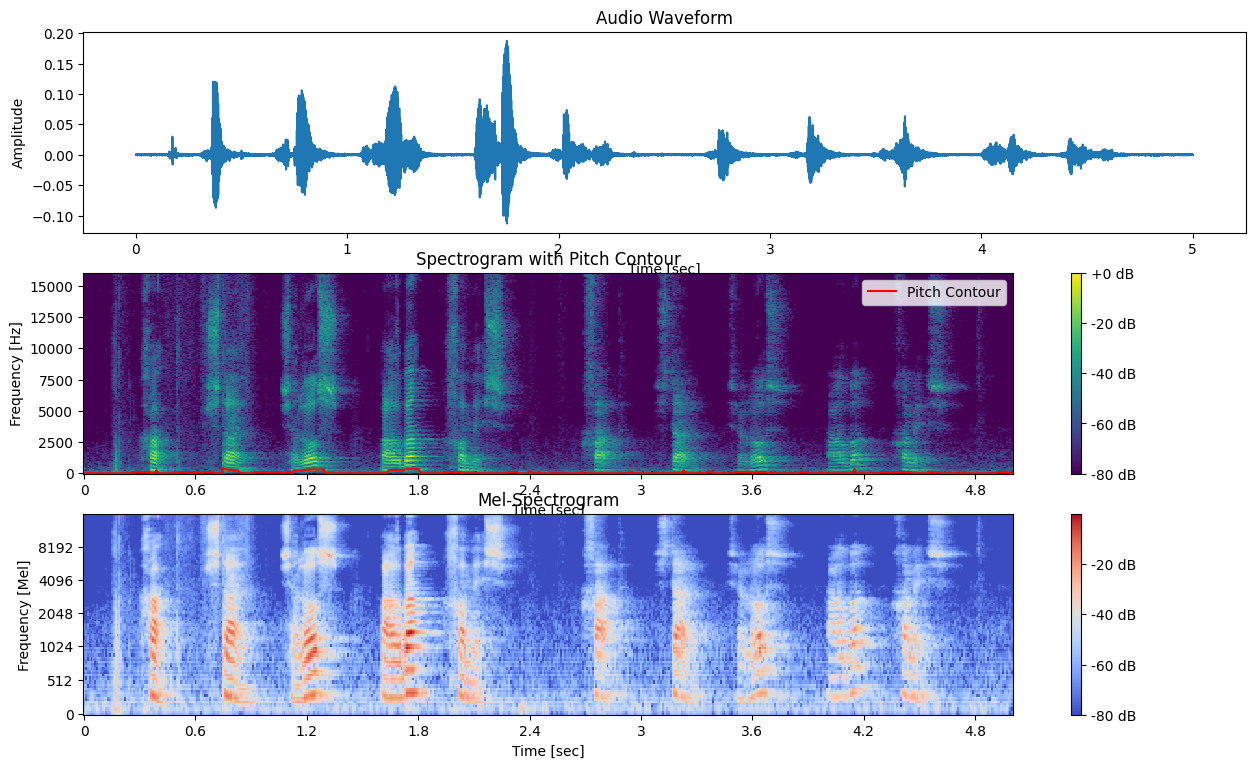

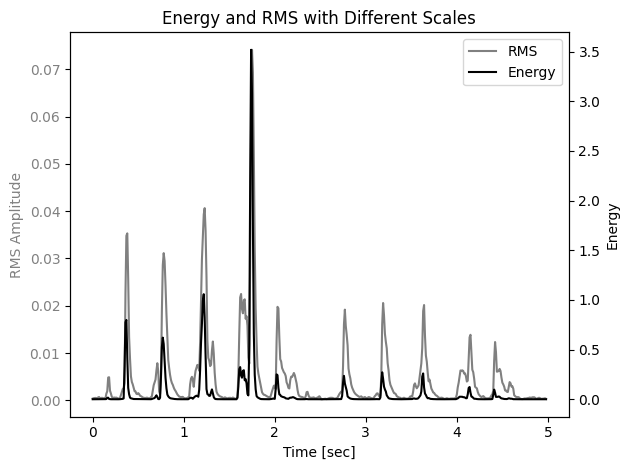

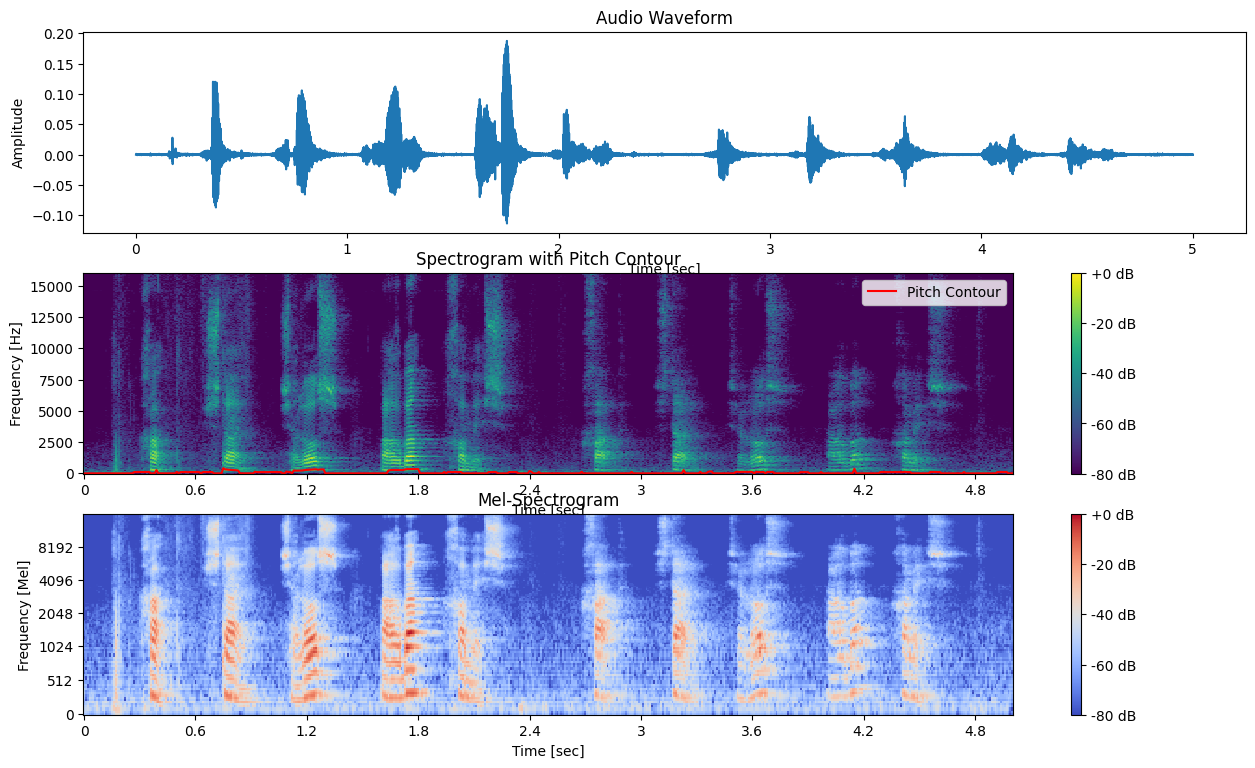

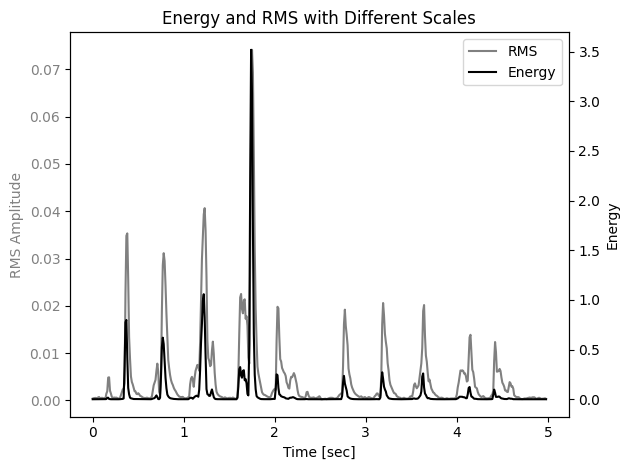

In [12]:
plot_audio(resampled_16_1,32000)
plot_audio(resampled_16_2,32000)

In [13]:
import IPython.display as ipd

ipd.display(ipd.Audio(resampled_16_1, rate=16000))  
ipd.display(ipd.Audio(resampled_16_2, rate=16000))  

The even sample 16_1 - is a bit disorted 

The scipy sound a bit smoother 

This may happen because in skiping samples direcyly high-frequency components in the original audio may alias into lower frequencies, creating distortion

2. Adding noise:
    
    a. Load the stationary_noise.wav audio file, and resample it to 16KHz.
    
    b. Add the noise to the audio from Q1.c.2 using ‘+’ operator. If you need to truncate
        it, do so.
    
    c. Plot the audio, noise, and noisy audio signals.

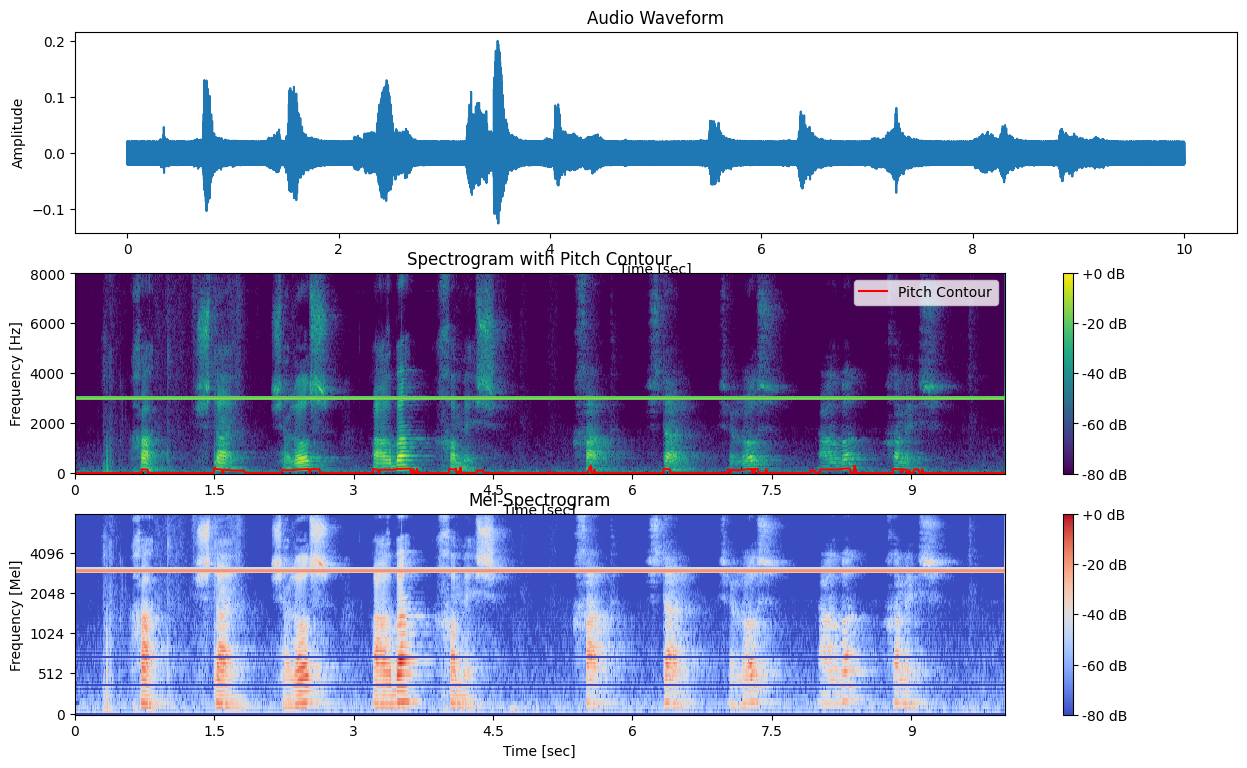

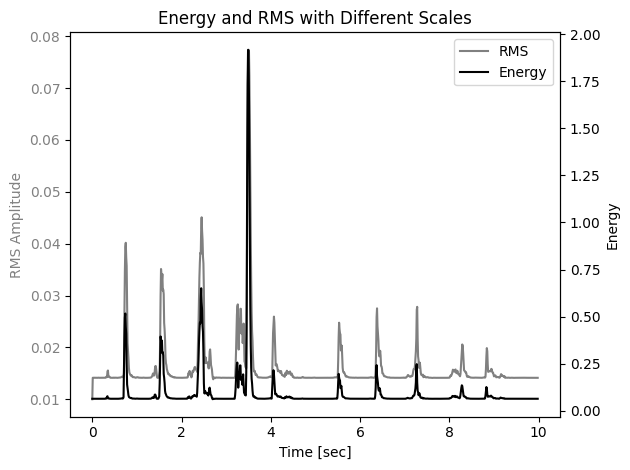

In [15]:
st_audio, st_sr = librosa.load('stationary_noise.wav', sr=None, mono=True)
duration = int(len(st_audio)/st_sr)
n_sample = 16000 * duration
resampled_st_16 = scipy.signal.resample(st_audio, n_sample)
min_length = min(len(resampled_st_16), len(resampled_16_2))
audio_resampled_truncated = resampled_16_2[:min_length]
noise_resampled_truncated = resampled_st_16[:min_length]
added_audio = audio_resampled_truncated + noise_resampled_truncated
plot_audio(added_audio, 16000)
ipd.display(ipd.Audio(added_audio, rate=16000))  


3. Implement and apply spectral subtraction to enhance the noisy signal from Q2.b

a. Find the speech parts (voice activity detection) using a threshold on the energy
level.

i. Set up the threshold and plot its value over the energy contour .



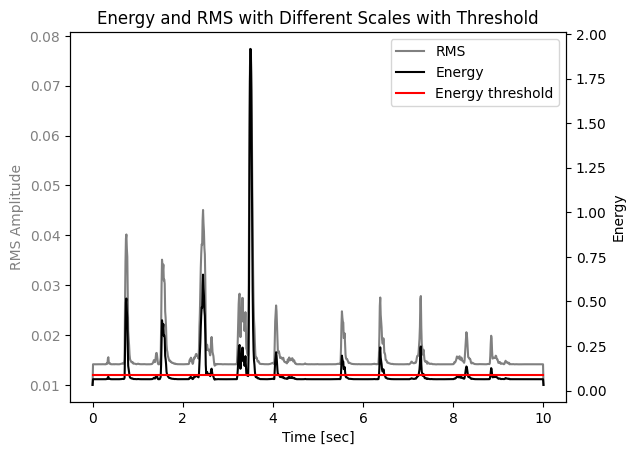

In [27]:
audio, sr = added_audio, 16000
window_size = 0.02  # 20ms
hop_size = 0.01  # 
hop_length = int(hop_size * sr)
n_fft = int(sr * window_size)
    
 # iv. Energy and RMS
rms = librosa.feature.rms(y=audio, frame_length=n_fft, hop_length=hop_length)
energy = (rms**2) * n_fft  # RMS^2 * frame_length gives energy

# Generate a time axis for plotting
time_rms = np.arange(rms.shape[1]) * hop_size  # Number of frames matches RMS


# Plot RMS on the primary Y-axis
fig, ax1 = plt.subplots()
ax1.plot(time_rms, rms[0], label="RMS", color="gray")
ax1.set_xlabel("Time [sec]")
ax1.set_ylabel("RMS Amplitude", color="gray")
ax1.tick_params(axis='y', labelcolor="gray")

# Add the secondary Y-axis for energy
ax2 = ax1.twinx()
ax2.plot(time_rms, energy[0], label="Energy", color="black")
ax2.set_ylabel("Energy", color="black")
ax2.tick_params(axis='y', labelcolor="black")

plt.title("Energy and RMS with Different Scales with Threshold")

# Add the energy threshold
ax2.plot(time_rms, time_rms*0+0.09, label="Energy threshold", color="red")

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

plt.show()

b. For every time-frame, find its noise estimation (‘noise footprint’) and subtract it
from the signal. Apply this in a sequential manner

c. Plot the output using the function from Q1.d

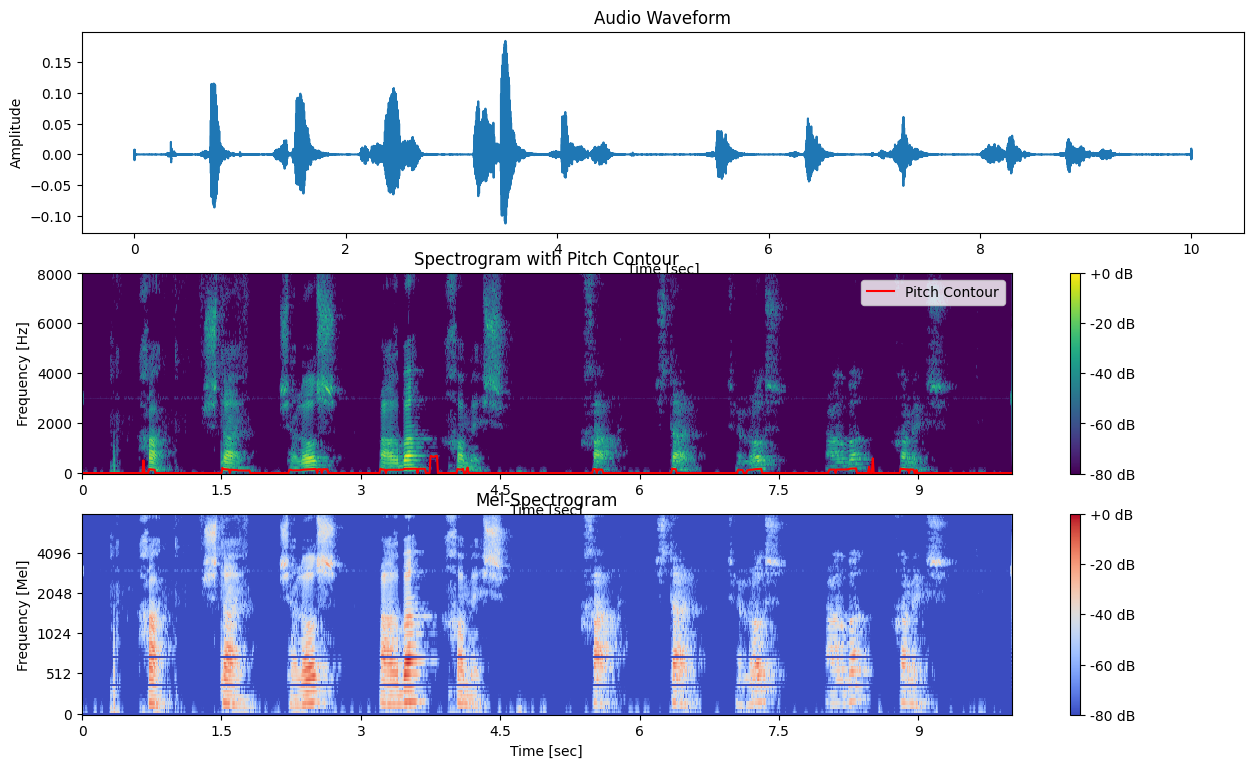

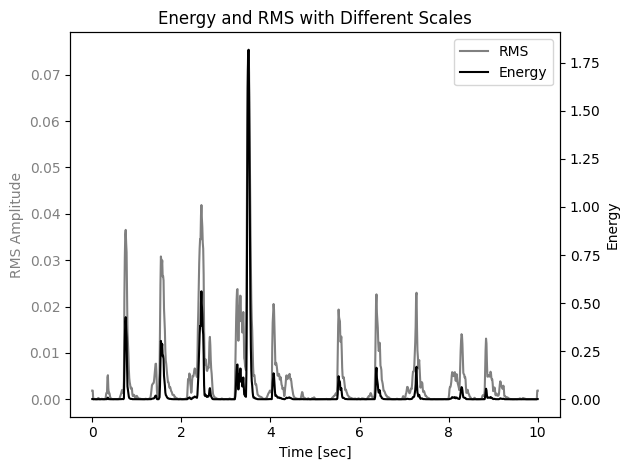

In [31]:
audio, sr = added_audio, 16000
window_size = 0.02  # 20ms
hop_size = 0.01  # 
hop_length = int(hop_size * sr)
n_fft = int(sr * window_size)
rms = librosa.feature.rms(y=audio, frame_length=n_fft, hop_length=hop_length)
energy = (rms[0]**2) * n_fft  # RMS^2 * frame_length gives energy

# Short-Time Fourier Transform (STFT) of the noisy audio
stft_noisy = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)

# Magnitude and phase
magnitude, phase = np.abs(stft_noisy), np.angle(stft_noisy)

# Estimate noise from non-speech frames
noise_estimation = np.mean(magnitude[:, energy < 0.09], axis=1, keepdims=True)


# Apply spectral subtraction
magnitude_denoised = np.maximum(magnitude - noise_estimation, 0)


# Reconstruct the signal using inverse STFT
stft_denoised = magnitude_denoised * np.exp(1j * phase)
enhanced_audio = librosa.istft(stft_denoised, hop_length=hop_length)

ipd.display(ipd.Audio(enhanced_audio, rate=16000))  
plot_audio(enhanced_audio,sr)



4. The audio segment from Q1.c.2 contains loud and soft speech segments, recorded
when the speakers were close /distant from the microphone, respectively.

a. Apply Auto Gain Control (AGC) on the audio from Q1.c.2

i. Determine the desired RMS in dB.

ii. Determine the noise floor threshold.

iii. For every time-frame, find its relevant gain and amplify/attenuate
accordingly (using statistics based on a window of ~1s). Apply this in a
sequential manner

iv. Make sure you don’t have overflow in the audio after amplifying. You can
use a sigmoid function to avoid clipping.

v. Plot the output using the function from Q1.d.

vi. Plot the scaling factors vs time.

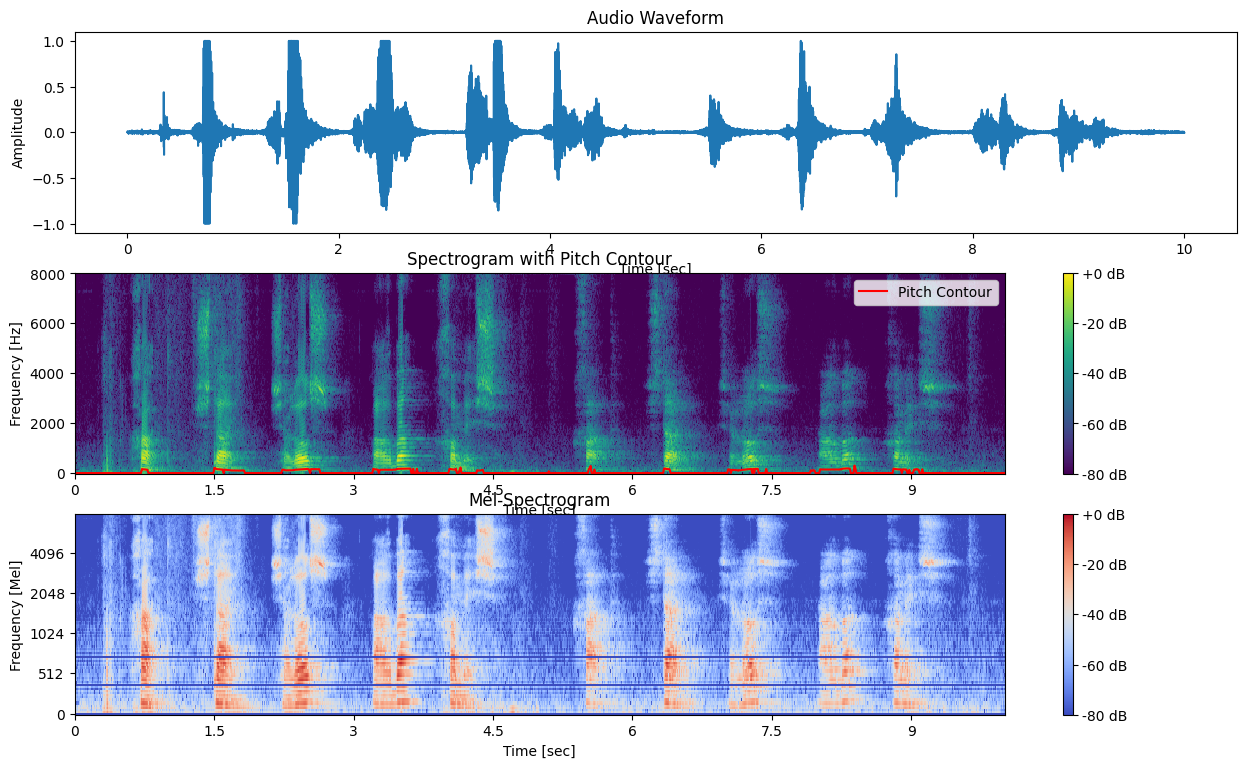

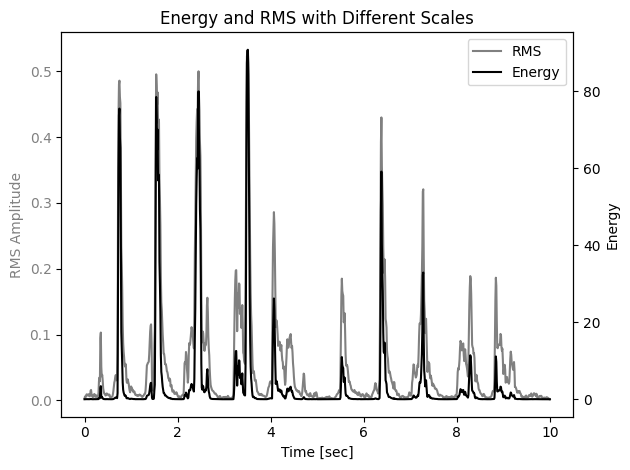

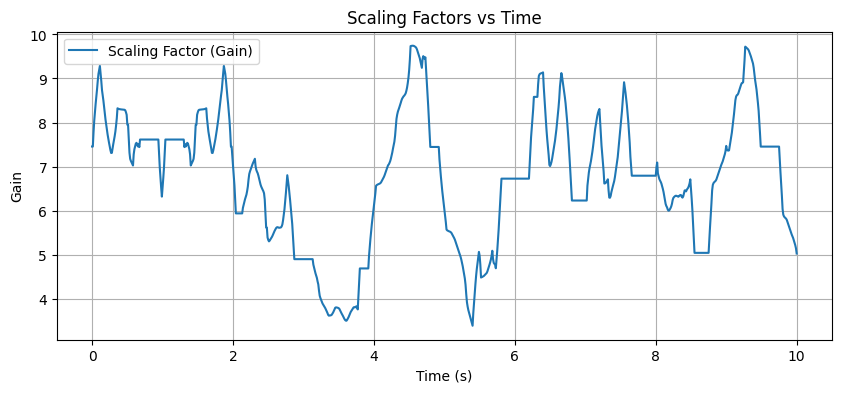

In [32]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd

# Constants
desired_RMS = 0.035
noisefloor_threshold = 0.001
window_size = 0.02  # 20ms
hop_size = 0.01  # 10ms
sr = 16000

# Load audio
audio, sr = resampled_16_2, 16000

# Frame parameters
hop_length = int(hop_size * sr)
n_fft = int(sr * window_size)

# Calculate RMS and gain
rms = librosa.feature.rms(y=audio, frame_length=n_fft, hop_length=hop_length)
gain = np.zeros_like(rms[0])
for i, r in enumerate(rms[0]):
    gain[i] = desired_RMS / r if r > noisefloor_threshold else 1.0

# Smooth gain
def moving_average(arr, window_size):
    cumsum = np.cumsum(np.insert(arr, 0, 0))
    moving_avg = (cumsum[window_size:] - cumsum[:-window_size]) / window_size
    pad_size = len(arr) - len(moving_avg)
    return np.pad(moving_avg, (pad_size, 0), mode='reflect')

gain_smoothed = moving_average(gain, 100)
gain_smoothed = np.clip(gain_smoothed, 0.1, 10)  # Prevent excessive gain

# Apply gain
audio_agc = np.zeros_like(audio)
for i, g in enumerate(gain_smoothed):
    start = i * hop_length
    end = min(start + n_fft, len(audio))
    audio_agc[start:end] += audio[start:end] * g

# Avoid overflow
audio_agc = np.clip(audio_agc, -1.0, 1.0)

plot_audio(audio_agc, sr)
ipd.display(ipd.Audio(audio_agc, rate=sr))

time = np.arange(len(gain_smoothed)) * hop_size  # Time in seconds
plt.figure(figsize=(10, 4))
plt.plot(time, gain_smoothed, label="Scaling Factor (Gain)")
plt.title("Scaling Factors vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Gain")
plt.grid(True)
plt.legend()
plt.show()

5. Using the audio from Q1.c.2, increase the speed of the audio by factor of x1.5, while
preserving the pitch.

a. Apply a time stretching algorithm using the phase vocoder.

. Set the mapping between the input and output.

ii. Apply STFT on the audio signal

iii. Calculate the magnitude and phase values of the output

iv. Apply iSTFT and listen to the audio.

v. Plot the signals in the time domain and spectral domain.

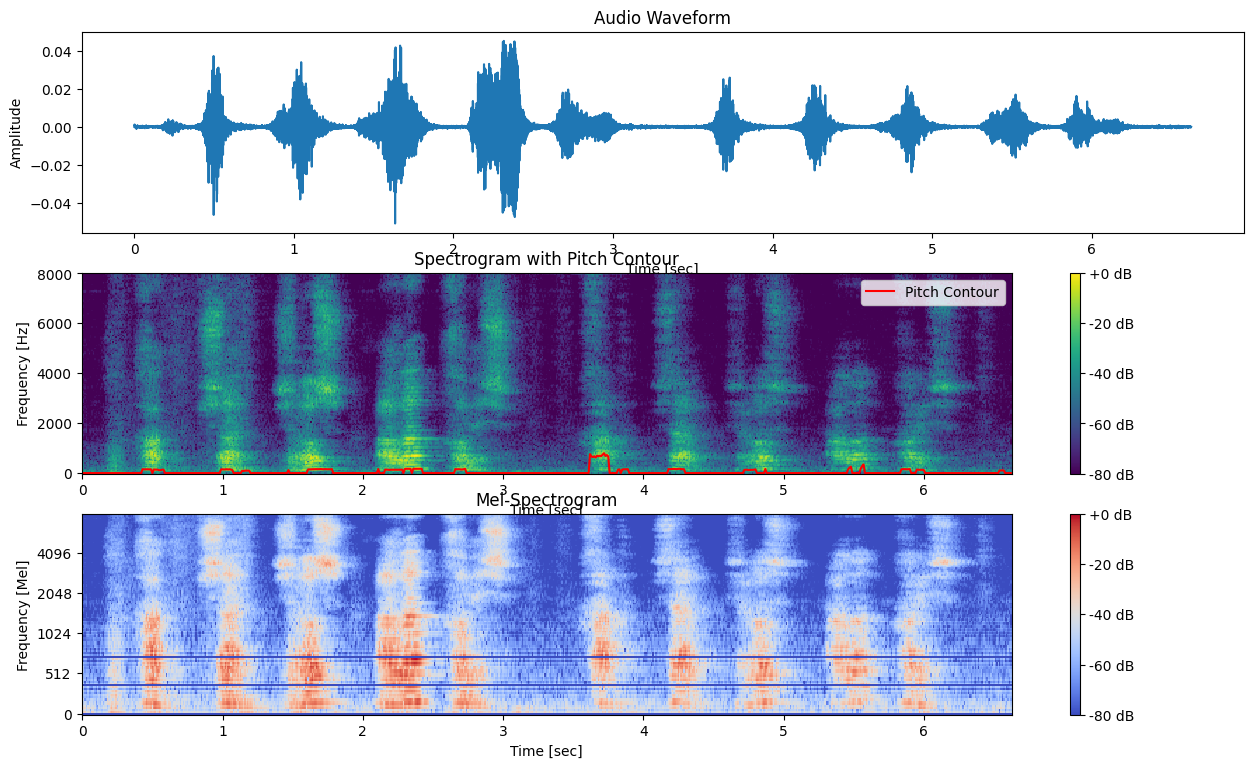

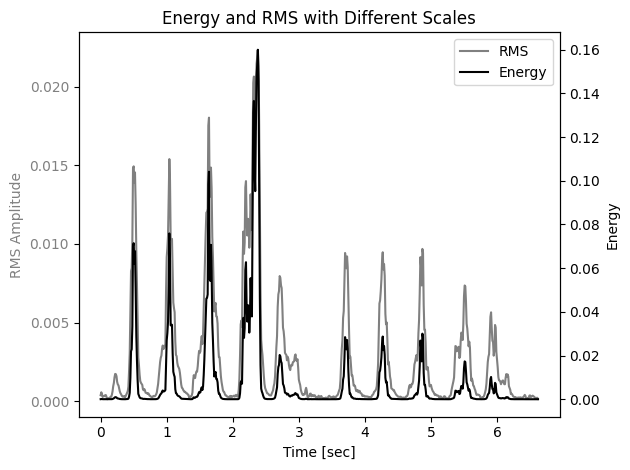

In [34]:
import math
import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

# Constants
scale = 1.5  # Speed-up factor
n_fft = 2048
hop_length = 512

# Load audio
audio, sr = resampled_16_2, 16000

# Compute STFT
stft = librosa.stft(y=audio, n_fft=n_fft, hop_length=hop_length)
magnitude, phase = np.abs(stft), np.angle(stft)

# Number of frames in the output
num_output_frames = int(stft.shape[1] / scale)

# Function to map time with interpolation
def map_time(input, t, scale):
    low_idx = math.floor(t * scale)  # Lower index
    high_idx = min(math.ceil(t * scale), input.shape[1] - 1)  # Upper index
    alpha = t * scale - low_idx  # Weight for interpolation
    return input[:, low_idx] * (1 - alpha) + input[:, high_idx] * alpha

# Rescale magnitude
magnitude_scaled = np.zeros((magnitude.shape[0], num_output_frames))
for t_out in range(num_output_frames):
    magnitude_scaled[:, t_out] = map_time(magnitude, t_out, scale)

# Adjust phase
phase_acc = np.zeros((phase.shape[0], num_output_frames))  # Adjusted phase
phase_acc[:, 0] = phase[:, 0]  # Initialize with the first frame's phase

for t_out in range(1, num_output_frames):
    t_in = t_out * scale
    low_idx = math.floor(t_in)
    high_idx = min(math.ceil(t_in), phase.shape[1] - 1)
    alpha = t_in - low_idx
    phase_increment = phase[:, high_idx] - phase[:, low_idx]  # Interpolated phase increment
    phase_increment = np.mod(phase_increment + np.pi, 2 * np.pi) - np.pi  # Wrap phase to [-π, π]
    phase_acc[:, t_out] = phase_acc[:, t_out - 1] + phase_increment

# Recombine scaled magnitude and adjusted phase
stft_output = magnitude_scaled * np.exp(1j * phase_acc)

# Reconstruct audio
audio_time_stretched = librosa.istft(stft_output, hop_length=hop_length)


plot_audio(audio_time_stretched, sr)
ipd.display(ipd.Audio(audio_time_stretched, rate=sr))